In [2]:
import numpy as np 
import pandas as pd
import cplex # community edition
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
D:\installation\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
arg_source = pd.read_csv('D:/jupyter_dir/yancao/data/step1.csv')
arg_source.head()

# 参数和决策变量
price = arg_source['单箱价格'].values
sold = arg_source['上期销售量'].values 
cap = arg_source['产能'].values

sold_obj = 2300   # 目标销量(箱)
price_obj = 40000 # 目标结构(元/箱)
I = price.size

In [92]:
var = [i for i in map(lambda x: 'x(' + str(x) + ')', list(range(arg_source.shape[0])))] # ['x(0)', 'x(1)', ...]
lp = '' # lp文件内容

# p1: 一次项 x1 x2 x3 ...
p1 = ''
for i in range(len(cap)):
    p1 += ' - %s x(%s)'%((2/sold + I/(125*sold_obj))[i], i)

# p2: 二次项 x1^2 x2^2 ... (已经乘2)
p2 = ''
for i in range(len(cap)):
    p2 += ' + %s x(%s)^2'%((2/(sold**2) + (2*I)/(sold_obj*250)**2)[i], i)

# p3: 交叉二次项 x1x2 x1x3 ... (已经乘2)
p3 = ''
for i in range(len(cap)):
    for j in range(i+1, len(cap)):
        p3 += ' + %s x(%s) * x(%s)'%(4*I/(250*sold_obj)**2,i,j)

lp += ('Minimize\n obj:' + p1 + ' +[' + p2 + p3 + ']/2\n')

# 约束条件

# p4: Σx_i*price
p4 = ''
for i in range(len(cap)):
    p4 += ' + %s x(%s)'%(price[i]/250, i)

lp += '\nSubject To\n'
lp += ' c1: %s >= %s \n'%(p4, 0.9*sold_obj*price_obj)
lp += ' c2: %s <= %s \n'%(p4, 1.1*sold_obj*price_obj)
for i in range(len(cap)):
    lp += ' c%s: x(%s) - Rgc%s = 0\n'%(3+i, i, i)
lp += 'Bounds\n'
for i in range(len(cap)): 
    lp += 'x(%s) Free\n'%i
for i in range(len(cap)): 
    lp += ' 0 <= Rgc%s <= %s \n'%(i, cap[i])
lp += 'General\n'
for i in range(len(cap)): lp += ' %s'%(var[i])
lp += '\nEnd'

with open('write.lp', 'w') as f:
    f.write(lp)

my_prob = cplex.Cplex('write.lp')
my_prob.solve()

x = my_prob.solution.get_values()
sold_next = np.array(x, dtype='int')[0:int(len(x)/2)]
sold_next

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 71 rows and 71 columns.
MIQP Presolve modified 2 coefficients.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.02 sec. (0.59 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 71 columns, and 142 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.00 sec. (0.45 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (5.30 ticks)

        Nodes                                         Cuts/
   Node  Left   

In [77]:
# 销量偏差百分比
delta_sold = (sold_obj - sold_next.sum()/250)/sold_obj
delta_price = (price_obj - (sold_next*price).sum()/(sold_next.sum()))/price_obj
delta_sale = (sold_obj*price_obj - (sold_next*price).sum()/250)/(sold_obj*price_obj)
delta_change = ((sold_next-sold)/sold).mean()
print('销量偏差：%.2f \n结构偏差：%.2f\n销售额偏差：%.2f\n销量变动程度：%.2f'%(delta_sold, delta_price, delta_sale, delta_change))

销量偏差：0.01 
结构偏差：-0.03
销售额偏差：-0.02
销量变动程度：0.01


In [78]:
def model(sold_obj, price_obj):
    var = [i for i in map(lambda x: 'x(' + str(x) + ')', list(range(arg_source.shape[0])))] # ['x(0)', 'x(1)', ...]
    lp = '' # lp文件内容

    # p1: 一次项 x1 x2 x3 ...
    p1 = ''
    for i in range(len(cap)):
        p1 += ' - %s x(%s)'%((2/sold + I/(125*sold_obj))[i], i)

    # p2: 二次项 x1^2 x2^2 ... (已经乘2)
    p2 = ''
    for i in range(len(cap)):
        p2 += ' + %s x(%s)^2'%((2/(sold**2) + (2*I)/(sold_obj*250)**2)[i], i)

    # p3: 交叉二次项 x1x2 x1x3 ... (已经乘2)
    p3 = ''
    for i in range(len(cap)):
        for j in range(i+1, len(cap)):
            p3 += ' + %s x(%s) * x(%s)'%(4*I/(250*sold_obj)**2,i,j)

    lp += ('Minimize\n obj:' + p1 + ' +[' + p2 + p3 + ']/2\n')

    # 约束条件

    # p4: Σx_i*price
    p4 = ''
    for i in range(len(cap)):
        p4 += ' + %s x(%s)'%(price[i]/250, i)

    lp += '\nSubject To\n'
    lp += ' c1: %s >= %s \n'%(p4, 0.9*sold_obj*price_obj)
    lp += ' c2: %s <= %s \n'%(p4, 1.1*sold_obj*price_obj)
    for i in range(len(cap)):
        lp += ' c%s: x(%s) - Rgc%s = 0\n'%(3+i, i, i)
    lp += 'Bounds\n'
    for i in range(len(cap)): 
        lp += 'x(%s) Free\n'%i
    for i in range(len(cap)): 
        lp += ' 0 <= Rgc%s <= %s \n'%(i, cap[i])
    lp += 'General\n'
    for i in range(len(cap)): lp += ' %s'%(var[i])
    lp += '\nEnd'

    with open('write.lp', 'w') as f:
        f.write(lp)
    
    my_prob = cplex.Cplex('write.lp')
    try:
        my_prob.solve()
        x = my_prob.solution.get_values()
    except:
        return np.nan, np.nan, np.nan, np.nan
        
    sold_next = np.array(x, dtype='int')[0:int(len(x)/2)]

    # 销量偏差百分比
    delta_sold = (sold_obj - sold_next.sum()/250)/sold_obj
    delta_price = (price_obj - (sold_next*price).sum()/(sold_next.sum()))/price_obj
    delta_sale = (sold_obj*price_obj - (sold_next*price).sum()/250)/(sold_obj*price_obj)
    delta_change = ((sold_next-sold)/sold).mean()
    return delta_sold, delta_price, delta_sale, delta_change

In [79]:
# 网格调优
ev_set = np.zeros([10,10,4])

for s in range(10):
    for p in range(10):
        ev_set[s,p] = model(sold_obj=1000+s*200, price_obj=30000+p*2000)

      14         
*     0+    0                         -141.5141     -141.5263             0.01%

Root node processing (before b&c):
  Real time             =    0.08 sec. (8.46 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.08 sec. (8.46 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 72 rows and 71 columns.
MIQP Presolve modified 1 coefficients.
Reduced MIQP has 1 rows, 71 columns, and 71 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 5041 nonzeros.
Presolve time = 0.02 sec. (0.57 ticks)
Tried aggregator 1 time.
Reduced MIQP has 1 rows, 71 columns, and 71 nonzeros.
Reduced MIQP has 0 binaries, 71 generals, 0 SOSs, and 0 i

Text(0.5, 60.0, 'price_obj')

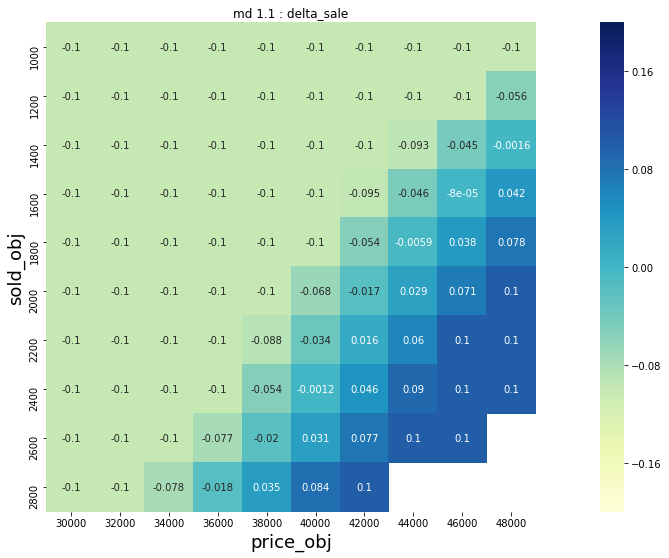

In [90]:
# 可视化delta_sold, delta_price, delta_sale, delta_change

hm_data = pd.DataFrame(ev_set[:,:,2])
hm_data.index = [1000+s*200 for s in range(10)]
hm_data.columns = Y = [30000+p*2000 for p in range(10)]

import seaborn as sns
fig, ax = plt.subplots(figsize = (23,9))
sns.heatmap(hm_data, annot=True, vmax=0.2,vmin = -0.2, xticklabels= True,yticklabels= True, square=True, cmap="YlGnBu")

ax.set_title('md 1.1 : delta_sale')
ax.set_ylabel('sold_obj', fontsize = 18)
ax.set_xlabel('price_obj', fontsize = 18)